In [289]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import scipy as scp
import arviz as az
import pandas as pd

%config InlineBackend.figure_format = 'retina'
az.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

Let's revisit the globe tossing example at the top.

p = probability of water
w = number of water
n = number of trials

P(p|w,n) 
= (P(w,n|p) * P(p)) / P(w,n)
= (P(w|n,p) * P(p)) / 

pmf, or pdf, gives the probability of p given a 


In [17]:
# generate 
random = lambda: np.random.rand() * 2 - 1

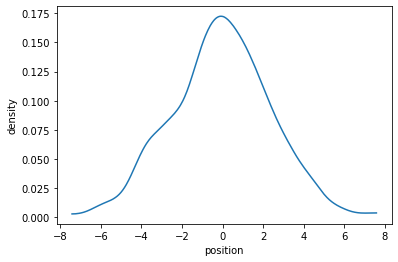

In [72]:
def density_plot(x, smoothness=None):
    params = {}
    if smoothness:
        params['bw_fct'] = smoothness
    grid, pdf = az.stats.kde(x, **params)
    plt.plot(grid, pdf)
    plt.xlabel('position')
    plt.ylabel('density')

# randomly walk 16 steps, then repeat the experiment 1000 times
x = np.array([(np.random.rand(16) * 2 - 1).sum() for _ in range(1000)])

density_plot(x) # looks normal

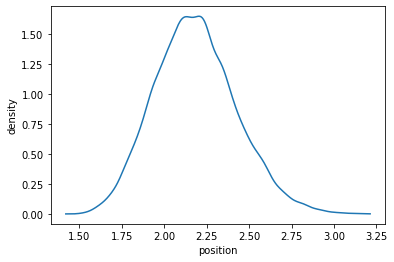

In [69]:
# multiply 16 numbers together, then repeat the experiment 10000 times
x = np.array([(np.random.rand(16) * 0.1 + 1).prod() for _ in range(10000)])

density_plot(x) # looks normal


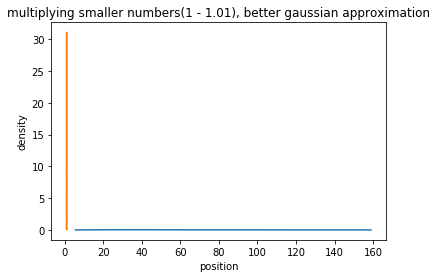

In [20]:
# Multiplying small numbers can be approximated by addition

# 1.1 x 1.1 = 1.21

# 1.1 x 1.1 = (1 + 0.1)(1 + 0.1) = 1 + 0.2 + 0.01

x = np.array([(np.random.rand(16) * 0.5 + 1).prod() for _ in range(10000)])
plt.title('multiplying larger numbers(1 - 1.5), not looking like gaussian')
density_plot(x)

x = np.array([(np.random.rand(16) * 0.01 + 1).prod() for _ in range(10000)])
plt.title('multiplying smaller numbers(1 - 1.01), better gaussian approximation')
density_plot(x) # looks normal

why? because adding logs is like multiplying...


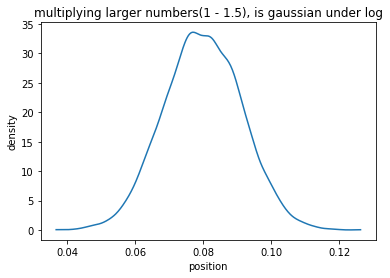

In [21]:
x = np.array([np.log((np.random.rand(16) * 0.01 + 1).prod()) for _ in range(10000)])
plt.title('multiplying larger numbers(1 - 1.5), is gaussian under log')
density_plot(x) # looks normal
print('why? because adding logs is like multiplying...')

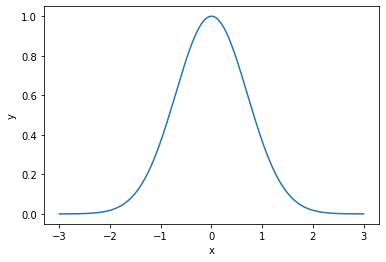

In [22]:
# even exp(-y^2) yields a gaussian like distribution...

x = np.linspace(-3, 3, 1000)
y = np.exp(-x**2)
plt.plot(x,y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

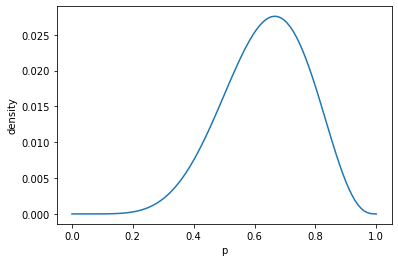

In [53]:
# formalizing the code from earlier chapters:
from scipy.stats import binom

w, n = 6, 9
p_grid = np.linspace(0, 1, 100)
posterior = binom.pmf(k=w, n=n, p=p_grid)
posterior = posterior/posterior.sum()
plt.plot(p_grid, posterior)
plt.xlabel('p')
plt.ylabel('density')
plt.show()



In [8]:
d = pd.read_csv('data/howell.csv', sep=';')
d.head(10)

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
5,163.830,62.992589,35.0,1
6,149.225,38.243476,32.0,0
7,168.910,55.479971,27.0,1
8,147.955,34.869885,19.0,0
9,165.100,54.487739,54.0,1


In [9]:
d.describe()

,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
25%,125.095000,22.007717,12.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
75%,157.480000,47.209005,43.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


In [30]:
# filter for people 18 and over.
d2 = d[d.age >= 18]
d2.describe()

,height,weight,age,male
count,352.000000,352.000000,352.000000,352.000000
mean,154.597093,44.990486,41.138494,0.468750
std,7.742332,6.456708,15.967855,0.499733
min,136.525000,31.071052,18.000000,0.000000
25%,148.590000,40.256290,28.000000,0.000000
50%,154.305000,44.792210,39.000000,0.000000
75%,160.655000,49.292693,51.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


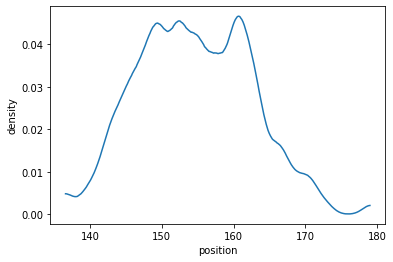

In [13]:
density_plot(d2.height) # for some reason this does not look quite normal.

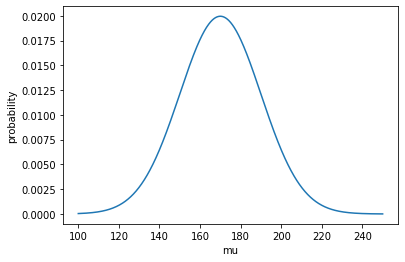

In [14]:
# lets plot our assumption of the prior, mu. We assume that it is centered at 170
# and has a std dev of 20. This means we expect 95% of probability of mu is
# 170 +-40 (2 standard deviations)
grid = np.linspace(100, 250, 1000)
probability = scp.stats.norm.pdf(grid, 170, 20)
plt.plot(grid, probability)
plt.xlabel('mu')
plt.ylabel('probability')
plt.show()

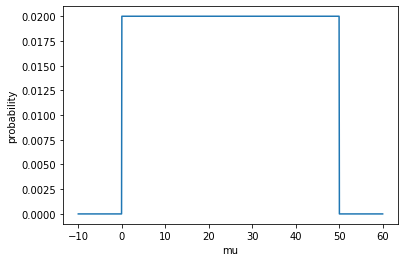

In [15]:
# then we can plot the prior for sigma, standard deviation.
# we assume that it is a uniform probability from 0 to 50
grid = np.linspace(-10, 60, 1000)
probability = scp.stats.uniform.pdf(grid, 0, 50)
plt.plot(grid, probability)
plt.xlabel('mu')
plt.ylabel('probability')
plt.show()

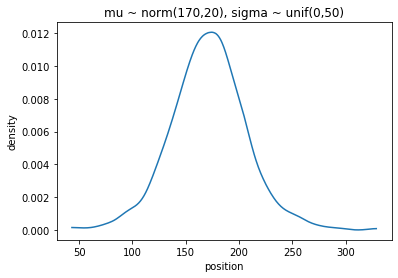

nonsensical plot, since it some of the heights are below 0


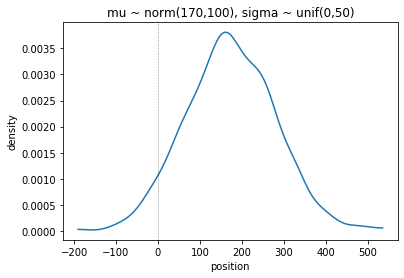

In [81]:
# so we are modeling heights as a gaussian, and we want to do prior predictive
# simulation. Meaning given our choice of priors, what are the outcomes of our
# gaussian distribution? do the values make sense?

# To get a gaussian distribution, we generate potential values 
# from all of our priors, mu and sigma. Using those priors, we simulate outcomes.
# The goal is that the actual data 'lines up' with the simulated outcomes.
# This is called *prior predictive* simulation

# In one of the simulations, mu ~ norm(170,100), we see that some values fall below 0,
# which makes no sense, since heights cannot be below 0. This means that
# mu ~ norm(170,100) is a poor prior for this data.

mu_sim_20 = scp.stats.norm.rvs(170, 20, 1000)
mu_sim_100 = scp.stats.norm.rvs(170, 100, 1000)
sigma_sim = scp.stats.uniform.rvs(0, 50, 1000)


plt.title('mu ~ norm(170,20), sigma ~ unif(0,50)')
samples = scp.stats.norm.rvs(mu_sim_20, sigma_sim)
density_plot(samples)
plt.show()

print('nonsensical plot, since it some of the heights are below 0')
plt.title('mu ~ norm(170,100), sigma ~ unif(0,50)')
samples = scp.stats.norm.rvs(mu_sim_100, sigma_sim)
density_plot(samples)
plt.axvline(0, linestyle='--', linewidth=0.5, color='black', alpha=0.5)
plt.show()




In [17]:
from itertools import product
def expand_grid(data_dict):
    """Create a dataframe from every combination of given values."""
    rows = product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())

print(expand_grid({'foo': [1,2], 'bar': ['4', '5', '6']}))


# mgrid method, which is faster, but perhaps harder to understand.

print('original mgrid')
print(np.mgrid[1:3:1, 4:7:1])
print('reshaped into 2 rows')
print(np.mgrid[1:3:1, 4:7:1].reshape(2,-1))
print('transposed')
print(np.mgrid[1:3:1, 4:7:1].reshape(2,-1).T)

   foo bar
0    1   4
1    1   5
2    1   6
3    2   4
4    2   5
5    2   6
original mgrid
[[[1 1 1]
  [2 2 2]]

 [[4 5 6]
  [4 5 6]]]
reshaped into 2 rows
[[1 1 1 2 2 2]
 [4 5 6 4 5 6]]
transposed
[[1 4]
 [1 5]
 [1 6]
 [2 4]
 [2 5]
 [2 6]]


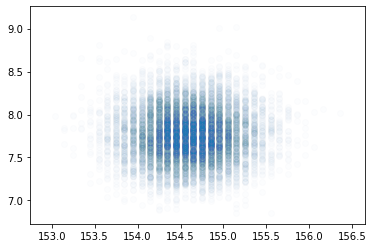

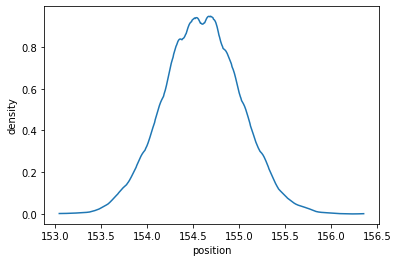

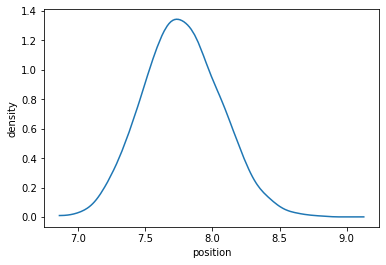

In [84]:


# now lets do grid estimation for the posterior of the gaussian distribution
# describing the heights of adults. Note, here, we are trying to determine
# the probability of the priors based on the data.
def estimate_gaussian(mu_vals, sigma_vals, data):
    # Log likelihood of posterior.
    # This step outputs every combination of mu and sigma.
    priors = expand_grid({'mu': mu_vals, 'sigma': sigma_vals})

    # We get the joint likelihood. For each mu-sigma combination,
    # Get the log pdf for each height i, then sum them(this really means
    # multiplying the probabilities together, but we sum because its in log space)
    sum_logpdf = lambda row: sum(scp.stats.norm.logpdf(data, row.mu, row.sigma))

    # applies this function for every row in the grid of mu sigma values
    posterior_ll = priors.apply(sum_logpdf, axis=1)

    # We also multiply this by the priors mu and sigma
    + scp.stats.norm.logpdf(priors.mu, 170, 20) + scp.stats.uniform.logpdf(priors.sigma, 4, 80)

    # Instead of doing exp, we scale first by the max value(to avoid 0s when exponentiating small numbers)
    posterior_prob = np.exp(posterior_ll - max(posterior_ll))
    
    # Skip plotting posterior probabilities directly, because there isn't a proper way
    # to do a contour plot.

    # Instead, inspect by sampling from the posterior.
    # To sample from the n-d posterior, we first generate an array of indexes,
    # based on posterior probabilities, with resampling.
    samples = np.random.choice(len(posterior_prob), size=10000, p=posterior_prob/posterior_prob.sum(), replace=True)

    # Then we index the priors with this array
    mu_test = priors.mu[samples].reset_index(drop=True)
    sigma_test = priors.sigma[samples].reset_index(drop=True)

    # Now we can easily do a scatterplot.
    plt.scatter(mu_test, sigma_test, alpha=0.01)
    plt.axis('equal')
    plt.grid(False)
    plt.show()
    density_plot(mu_test, smoothness=2)
    plt.show()
    density_plot(sigma_test, smoothness=3)
    plt.show()

mu_vals = np.linspace(140, 170, 300)
sigma_vals = np.linspace(6, 10, 300)
estimate_gaussian(mu_vals, sigma_vals, d2.height)

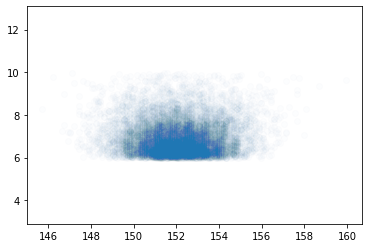

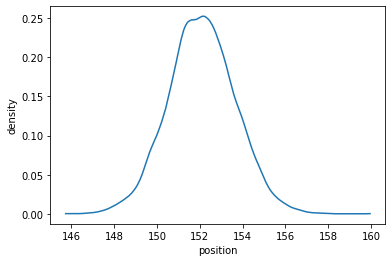

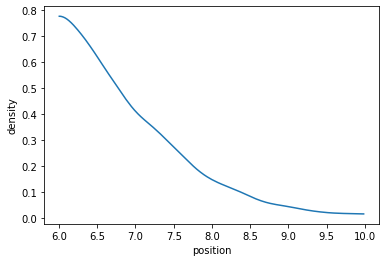

In [86]:
# now lets try with a fraction of the data
estimate_gaussian(mu_vals, sigma_vals, d2.height.sample(20))

# There is a long tail in the sigma val, because variances must be positive. when there is not enough data,
# there is more uncertainty about how big the sigma must be, rather than how small. for example, it cannot
# be below 0.


In [165]:

with pm.Model() as normal_aproximation:
    sigma = pm.Uniform('sigma', 0, 50)
    mu = pm.Normal('mu', 178, 20)
    prob = pm.Normal('prob', mu=mu, sigma=sigma, observed=d2.height)
    trace_4_1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


In [288]:
pm.summary(trace_4_1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,154.600,0.418,153.829,155.379,0.007,0.005,3715.0,2670.0,1.0
sigma,7.768,0.299,7.233,8.326,0.005,0.004,3294.0,2725.0,1.0


In [167]:
with pm.Model() as normal_aproximation:
    sigma = pm.Uniform('sigma', 0, 50)
    mu = pm.Normal('mu', 178, 0.1)
    prob = pm.Normal('prob', mu=mu, sigma=sigma, observed=d2.height)
    trace_4_2 = pm.sample()

#If we adjust the prior of mu to be really tight(small std dev), then the model
# adjusts. Here the estimate for mu hasnt moved much from the prior,
# and the sigma is much larger to account for it.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


In [168]:
#If we adjust the prior of mu to be really tight(small std dev), then the model
# adjusts. Here the estimate for mu hasnt moved much from the prior,
# and the sigma is much larger to account for it.
pm.summary(trace_4_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,177.864,0.102,177.672,178.053,0.002,0.001,3424.0,2768.0,1.0
sigma,24.605,0.946,22.835,26.346,0.016,0.011,3535.0,2964.0,1.0


In [203]:
# Get the covariance matrix for the data.
trace_4_1_df = pm.to_inference_data(trace_4_1).posterior.to_dataframe()
trace_4_1_cov = trace_4_1_df.cov() 

In [204]:
print(pd.Series(np.diag(trace_4_1_cov), index=[trace_4_1_cov.index]))
print(trace_4_1_df.corr())

mu       0.174349
sigma    0.089278
dtype: float64
             mu     sigma
mu     1.000000  0.001245
sigma  0.001245  1.000000


In [215]:
print(
"""cov() returns the variance covariance matrix for the nd gaussian. 
The diagonal is the variance of variable. See that these have the same output as the std dev
output by pm.summary.""")
print(np.sqrt(np.diag(trace_4_1_cov)))
pm.summary(trace_4_1).sd


cov() returns the variance covariance matrix for the nd gaussian. 
The diagonal is the variance of variable. See that these have the same output as the std dev
output by pm.summary.
[0.4175515  0.29879345]


mu       0.418
sigma    0.299
Name: sd, dtype: float64

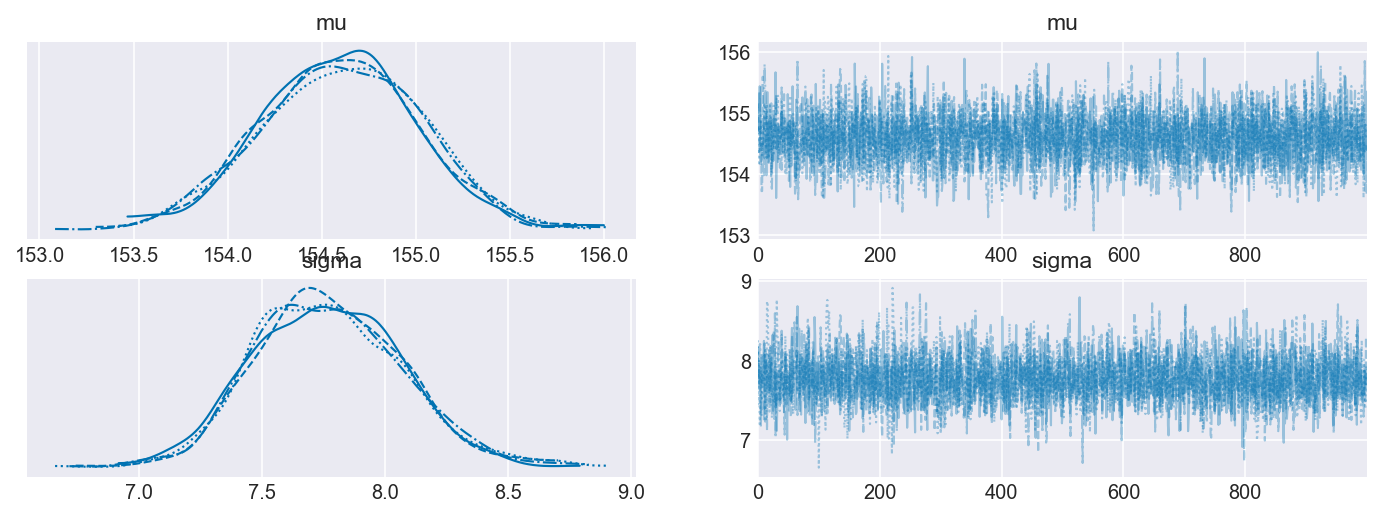

In [290]:
pm.plot_trace(trace_4_1);

In [248]:
# we can sample from the multivariate gaussian in this manner

scp.stats.multivariate_normal(pm.summary(trace_4_1)['mean'], trace_4_1_cov).rvs(size=10)

array([[154.28228574,   7.90670614],
       [155.43791238,   7.99660515],
       [154.48421571,   7.19121615],
       [154.58310274,   7.73075518],
       [154.28588166,   7.46092056],
       [154.40831281,   7.53984188],
       [154.07123433,   7.62863168],
       [154.03258964,   7.46093314],
       [154.09647483,   7.54066647],
       [153.92693396,   7.79071719]])

In [229]:
trace_4_1_cov.to_numpy()

array([[1.74349253e-01, 1.55283653e-04],
       [1.55283653e-04, 8.92775263e-02]])

In [241]:
pm.summary(trace_4_1)['mean']

mu       154.600
sigma      7.768
Name: mean, dtype: float64

In [247]:
trace_4_1_df.head()


mu     sigma
chain draw                      
0     0     155.077280  8.098591
      1     155.071788  7.837962
      2     154.711295  7.715270
      3     155.442419  7.920390
      4     154.164470  7.816756

Text(0, 0.5, 'weight(kg)')

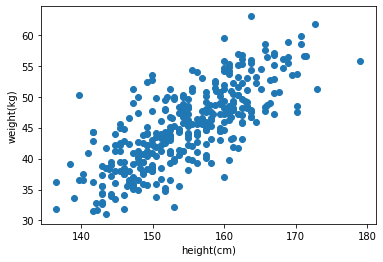

In [252]:
# Let's just plot height vs weight to see if there is any kind of correlation
# Indeed there is.

plt.scatter(d2.height, d2.weight)
plt.xlabel('height(cm)')
plt.ylabel('weight(kg)')

This shows us that the priors set for beta are not correct.
Some heights are predicted below 0 and some heights are way over normal


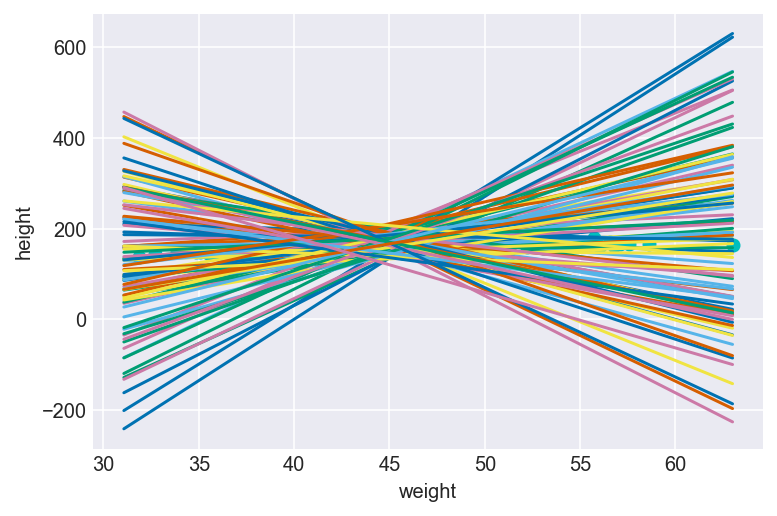

In [319]:
n = 100
# use random_state to control results exactly
alpha = scp.stats.norm.rvs(170,20, n, random_state=np.random.RandomState(seed=100))
beta = scp.stats.norm.rvs(0,10, n, random_state=np.random.RandomState(seed=101))

xs = np.linspace(d2.weight.min(), d2.weight.max(), n)
x_bar = d2.weight.mean()

print("This shows us that the priors set for beta are not correct.")
print("Some heights are predicted below 0 and some heights are way over normal")
plt.xlabel('weight')
plt.ylabel('height')
plt.plot(d2.weight[:n], d2.height[:n], 'co')
for i in range(n):
    # This is the linear regression
    ys = alpha[i] + beta[i] * (xs - x_bar)
    plt.plot(xs, ys)


This shows us that the priors set for beta are not correct.
Some heights are predicted below 0 and some heights are way over normal


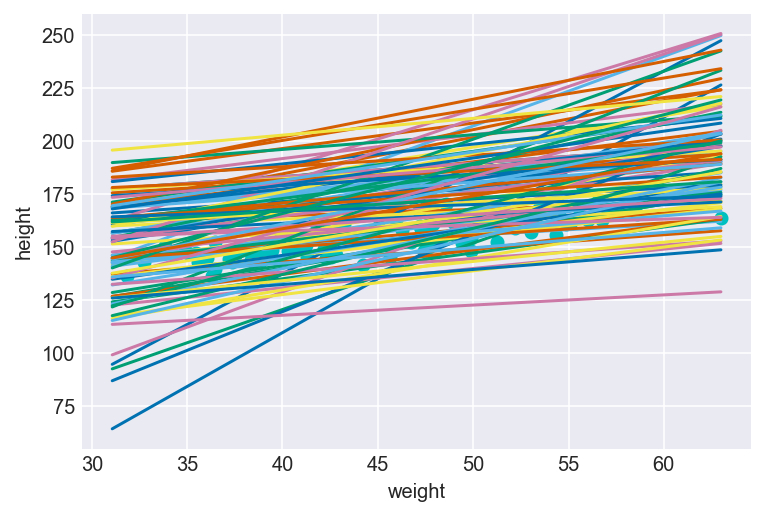

In [358]:
# Knowing that the previous priors are bad, we restrict heights to positive values
# We do so by using the log normal. Let's see what these values are like:


n = 100
# use random_state to control results exactly
alpha = scp.stats.norm.rvs(170,20, size=n, random_state=np.random.RandomState(seed=100))
beta = scp.stats.lognorm.rvs(0.6, size=n, random_state=np.random.RandomState(seed=101))

xs = np.linspace(d2.weight.min(), d2.weight.max(), n)
x_bar = d2.weight.mean()

print("The predicted heights are now more sane..")
plt.xlabel('weight')
plt.ylabel('height')
plt.plot(d2.weight[:n], d2.height[:n], 'co')
for i in range(n):
    # This is the linear regression
    ys = alpha[i] + beta[i] * (xs - x_bar)
    plt.plot(xs, ys)

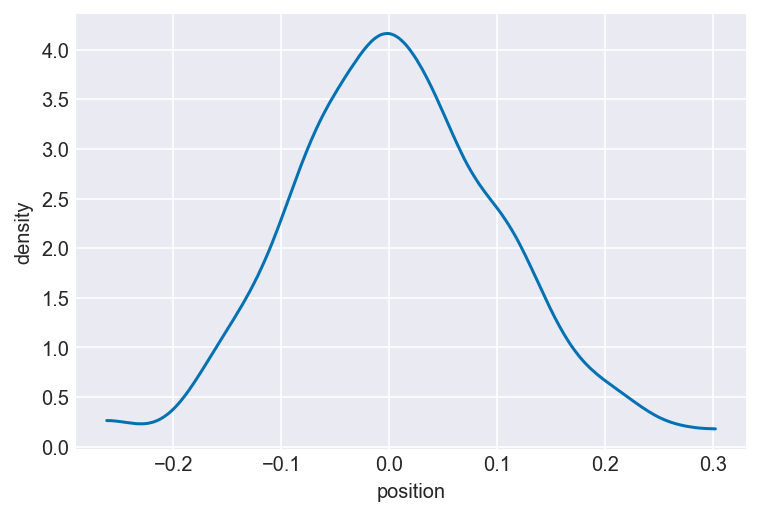

In [351]:

density_plot(scp.stats.lognorm.rvs(0.1, loc=-1, size=1000))

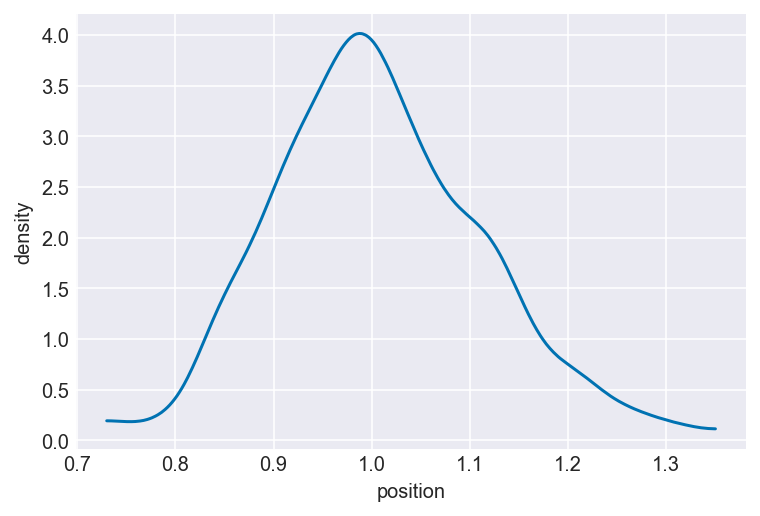

In [345]:
density_plot(scp.stats.lognorm.rvs(0.1, size=1000))

In [359]:
help(pm.summary)

Help on function summary in module arviz.stats.stats:

summary(data, var_names: Union[List[str], NoneType] = None, filter_vars=None, group=None, fmt: "Literal['wide', 'long', 'xarray']" = 'wide', kind: "Literal['all', 'stats', 'diagnostics']" = 'all', round_to=None, circ_var_names=None, stat_focus='mean', stat_funcs=None, extend=True, hdi_prob=None, skipna=False, labeller=None, coords=None, index_origin=None, order=None) -> Union[pandas.core.frame.DataFrame, xarray.core.dataset.Dataset]
    Create a data frame with summary statistics.
    
    Parameters
    ----------
    data: obj
        Any object that can be converted to an :class:`arviz.InferenceData` object
        Refer to documentation of :func:`arviz.convert_to_dataset` for details
    var_names: list
        Names of variables to include in summary. Prefix the variables by ``~`` when you
        want to exclude them from the summary: `["~beta"]` instead of `["beta"]` (see
        examples below).
    filter_vars: {None, "lik

In [ ]:
alpha